# Optical Character Recognition to extract text from a receipt

<span style="color:red">In this example we will use Optical Character Recognition (OCR) to extract text and price information from a receipt.</span>

<span style="color:red">This can be a challenging task if the receipt is not in pristine condition. For example, if the receipt is creased, the dark mark of the crease can distort or obscure text, making it difficult for the OCR algorithm to correctly identify characters. There are also added challenges for example where a user may have marked the receipt, the text is faded, or the text is misprinted. </span>

<span style="color:red">In this notebook, we will run through some techniques that could improve the OCR performance of the open source Tesseract, but naturally when looking at real  data it is very problem dependent so in practice you'll be trying lots of different things. Tesseract was initially developed by HP labs in Bristol and then taken on by Google. 

<span style="color:red">For further details of the algorithm and the latest developments, an overview of the Tesseract engine is given here:</span> https://github.com/tesseract-ocr/docs/blob/master/tesseracticdar2007.pdf

<span style="color:red">We'll be using the standard Tesseract module which includes a pretrained model, so there's no need to train on new characters. Generally, this seem  to work well with standard fonts in PDFs. There are later versions of tesseract that use more sophisticated techniques, including using recurrent Neural Networks (specifically LSTMs) as their engine:</span>

https://github.com/tesseract-ocr/tesseract/wiki/Documentation

## 1. Import Python Modules

In [1]:
import PyPDF2
import numpy as np
import io
from wand.image import Image
from PIL import Image as Im
from enchant.checker import SpellChecker
import os
import pytesseract
import cv2
import codecs
import regex as re 
from IPython.display import Image as Img

## 2. Load Image

<span style="color:red"> OpenCV can open an image the imread command. We can also use it to find the dimensions of the image and display the image. </span>

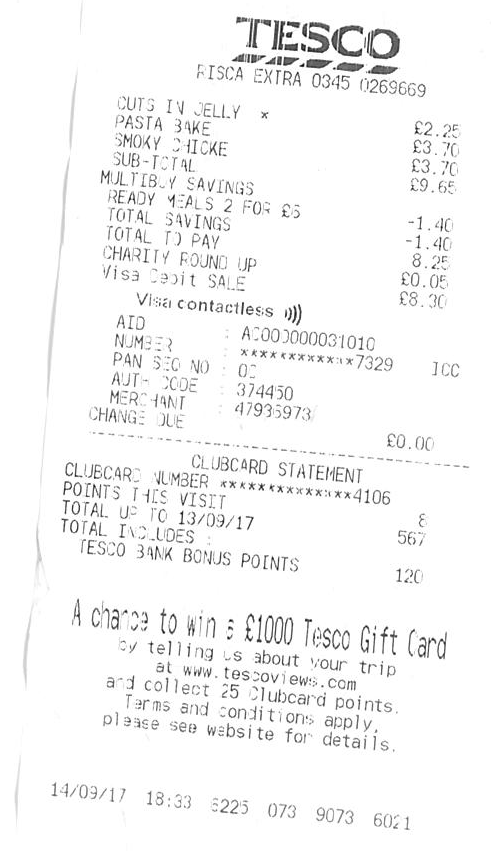

In [2]:
# load image as a greyscale image

img = cv2.imread('/home/mike/Dropbox/Receipt_OCR/Tesco1.png',0)

rows, cols = img.shape # find the dimensions of the image

#cv2.imshow('Receipt image', img)
#cv2.waitKey(0)
#cv2.DestroyAllWindows()

# alternatively, we can display the image inline
# I'll write this as a function so we can call it later in the notebook

def show_image(img):
    filename = "{}.png".format(os.getpid())
    cv2.imwrite(filename, img)
    return Img(filename)

show_image(img)

<span style="color:red">Here we can see some issues that will affect the OCR algorithm. The text is faded and some of the text has faded enough that it has disappeared. The image is also skewed which can lower the OCR performance. </span>

<span style="color:red">For example, if we run the algorithm on that raw image, the results from Tesseract are below:</span>

In [3]:
filename = "{}.png".format(os.getpid())
cv2.imwrite(filename, img)

text = pytesseract.image_to_string(Im.open(filename))

print text

SC‘D
Anvnr.'.-
HSCA EXTRA 03115 10269669
GUM H {‘ELH x
I’ASM 9W5
SHOW 1 GICKE
SUDJJML
MULHBM “WAN
READY “17 L3 2 )-
MML S‘WINGS

    

4m tonlarnless 0))
AIOOJOOOOEIOIC

xxxnxxxxxn7329 ICC

0
374450
479’? 39 M

   

£0.00

A IBCARD smrsmsm
5 muumu-mqwe
s vxsrr

f
0 13/09/17 56}
0E3

O 3003K ROMS POINTS

   
     

IIBI‘

0 shave to 0m 5 01000 ﬁasco Gift (ard

:y telling LS about yvour twp
' Ir .KBSSUVWEWMJDOHI
25 )lulmara‘ points
:oniit‘on-r apply,
as See website for details‘

  

1-1/09/1 7 13 ’

 

‘ 2‘5 073 9073 61m


<span style="color:red">As we can see, the results are awful! We wouldn't be able to extract anything useful from  this. So the idea here is to perform a number of preprocessing steps such that we give Tesseract the best possible chance of successful extraction. </span>

## 3. Threshold the image to convert it to binary black and white

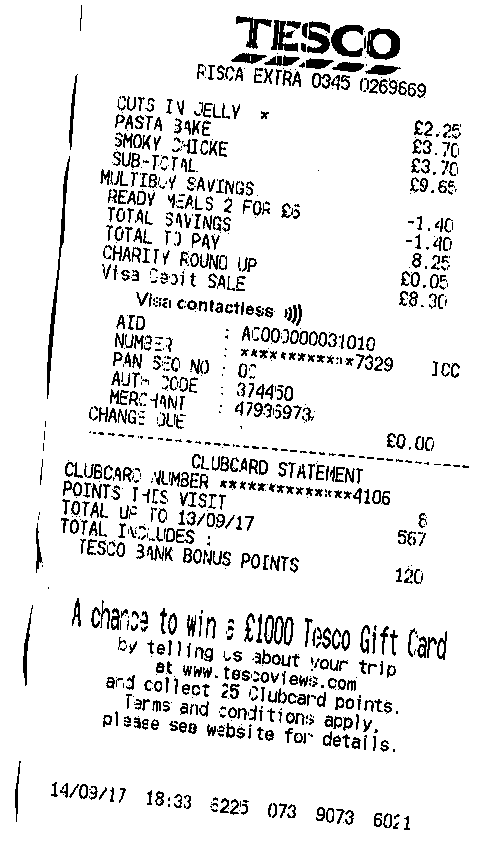

In [4]:
# Threshold to binary image. Choosing a value around 140 actually gets rid of the crease as 
# it's a light grey rather than black.  Could use Otsu's thresholding algorithm to automate this. 

num, img = cv2.threshold(img, 235, 255, cv2.THRESH_BINARY)

show_image(img)

## 4. Rotate the image to ensure the text is horizontally aligned

<span style="color:red">Tesseract generally works best when all of the text is horizontally aligned. Given an image is represented by a matrix (or tensor is it is a colour image), we can apply multiply it by a rotation matrix to align the text. </span>

<span style="color:red">You can do this by trial and error as I've done here, but it would be possible to automate the process too. One way would be to detect the lines of the edge of the receipt using, for instance, a Hough transform (https://en.wikipedia.org/wiki/Hough_transform), then finding the angle of skewness with reference to a horizontal line. </span>

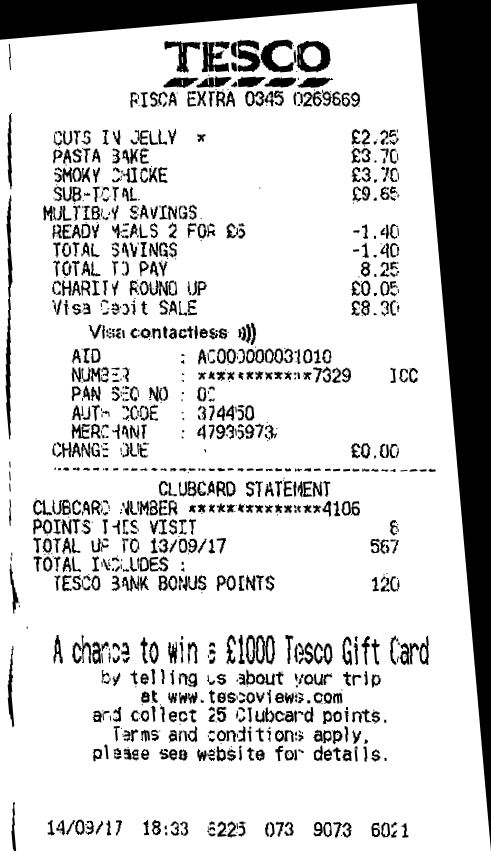

In [5]:
rotation_matrix = cv2.getRotationMatrix2D((cols,rows),5,1)
img = cv2.warpAffine(img,rotation_matrix,(cols,rows))

show_image(img)

## 5. Resize the image to make sure the text is clear

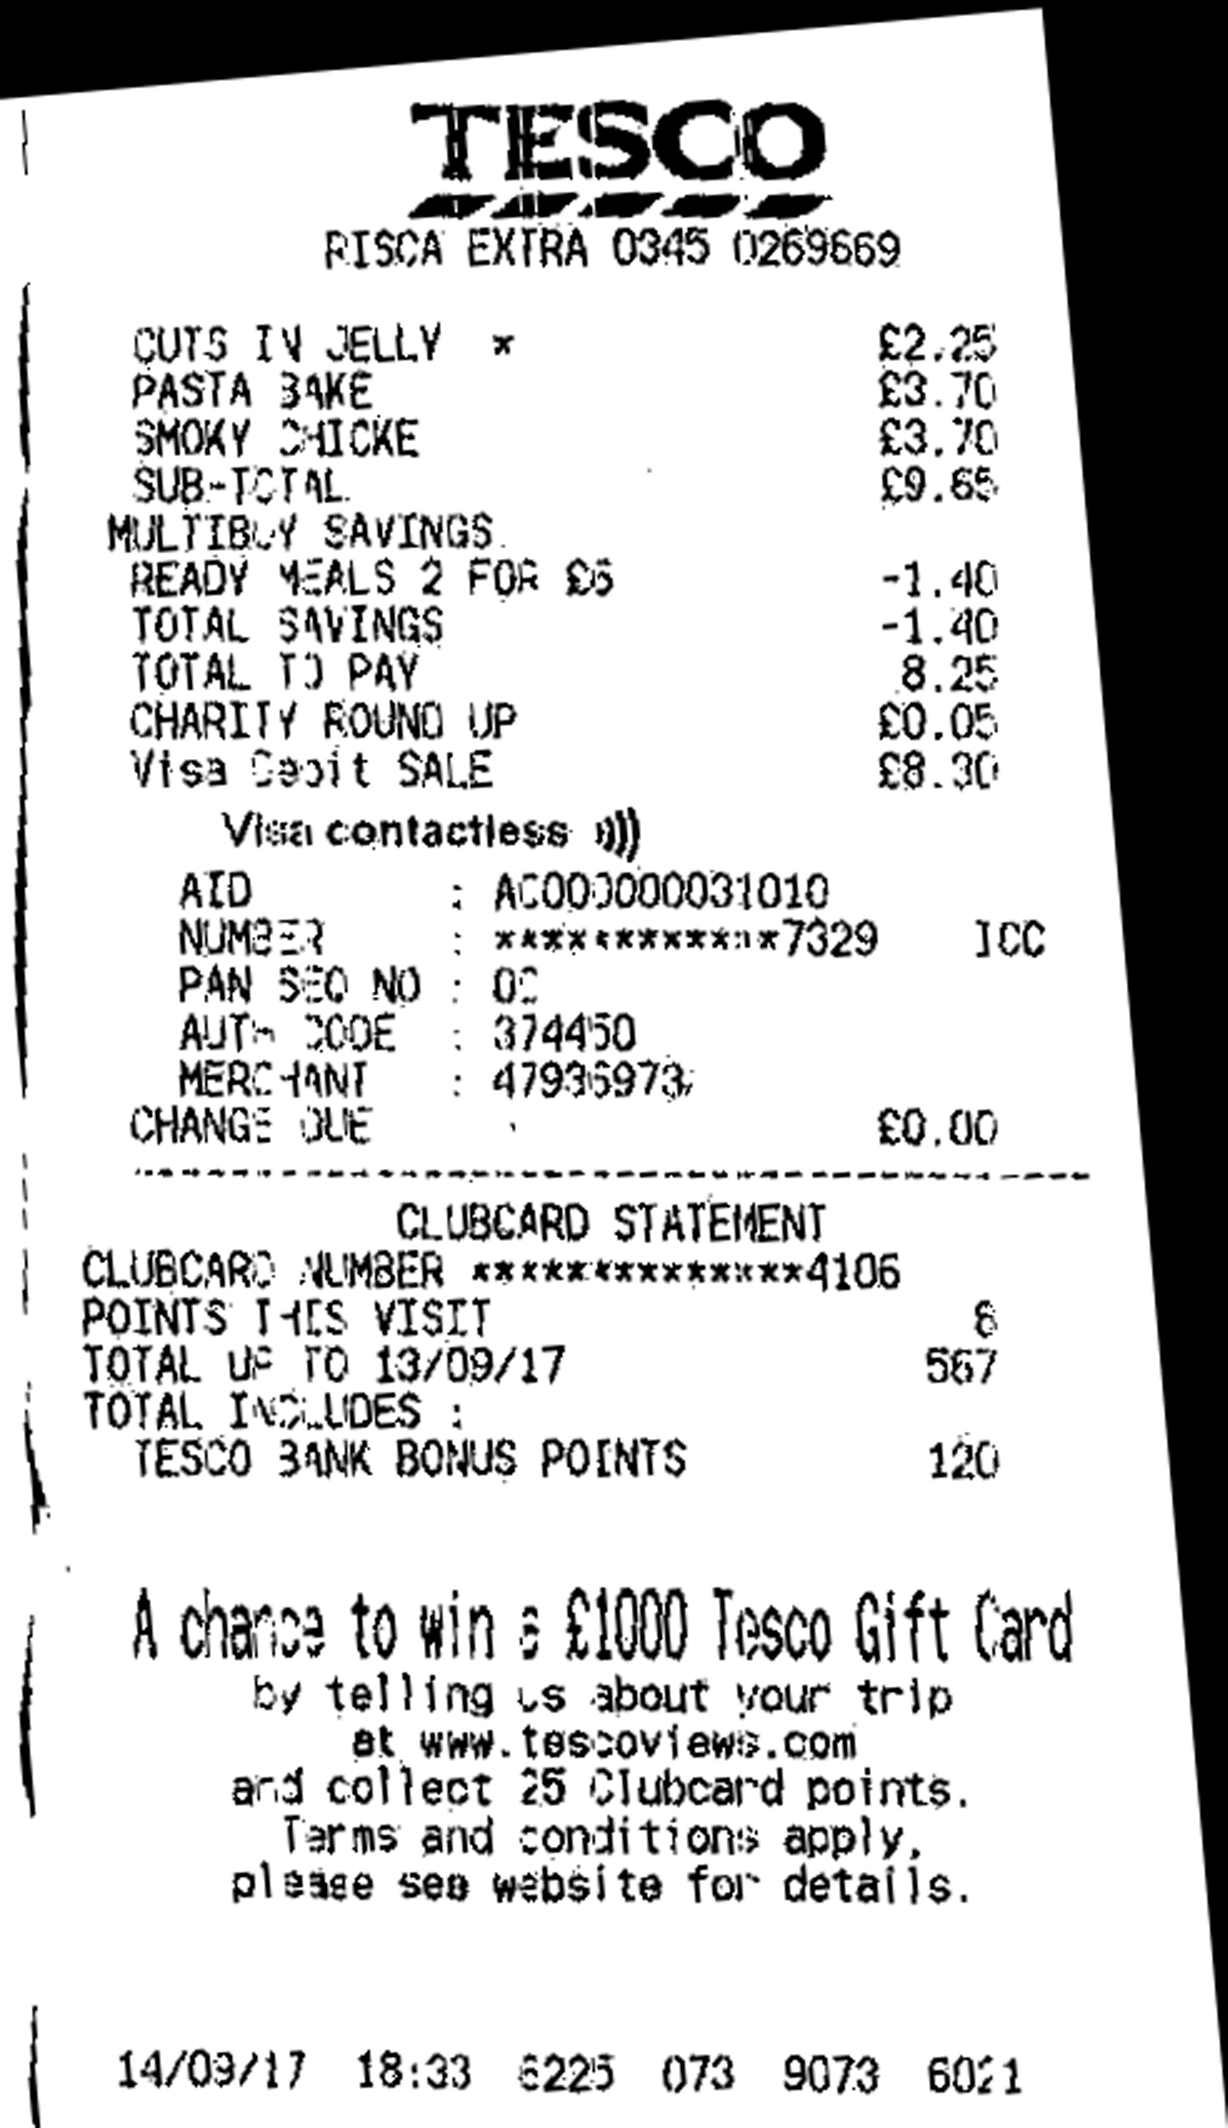

In [6]:
img = cv2.resize(img,None,fx=2.5, fy=2.5, interpolation = cv2.INTER_CUBIC) 

#uses cubic intepolation to approximate pixel values

show_image(img)


## 6. Morphological operations to make the text clearer

<span style="color:red">There are parts of the text missing where it has faded. Sometimes we can use morphological operations to connect nearby components, or trim excess bits of text. </span>

<span style="color:red">More information on mathematical morphology is given here: </span>https://en.wikipedia.org/wiki/Mathematical_morphology

<span style="color:red">We will using the operation of closing. This can connect nearby componenets, but as some characters have a lot missing, there isn't much we can do with morphology. </span>

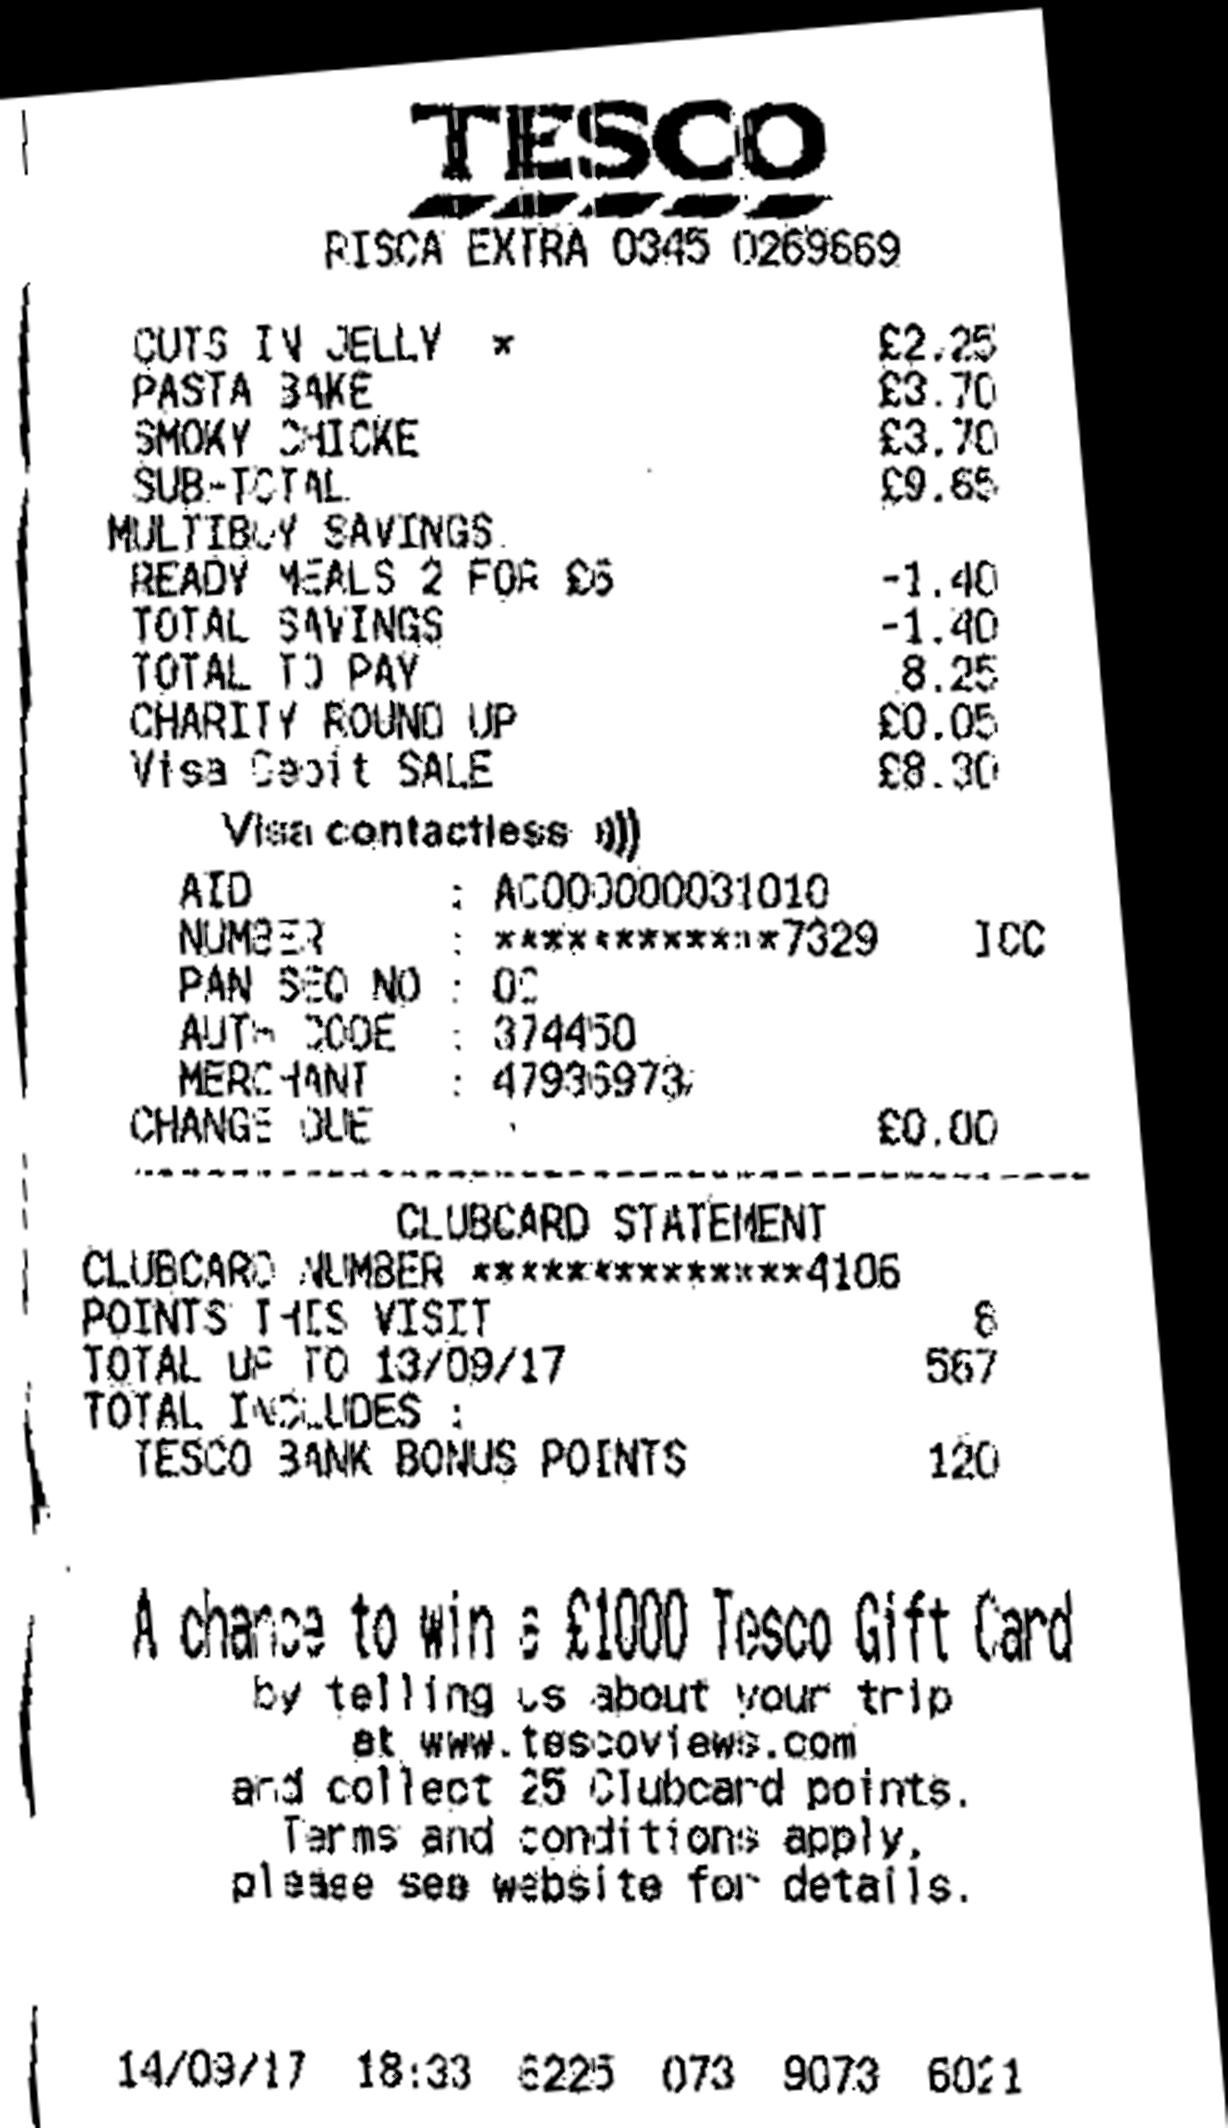

In [7]:
#kernel = np.ones(1, np.uint8)

img = 255 - img
kernel = np.array([[0,1,0],[1,1,1],[0,1,0]], np.uint8)
img1 = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
img1 = 255 - img1

show_image(img1)



## 7. Apply Tesseract OCR

In [8]:
filename = "{}.png".format(os.getpid())
cv2.imwrite(filename, img1)

text = pytesseract.image_to_string(Im.open(filename))

print text

TESOO

  
 

Alvnnurgllnalranrj
PISCA EXTRA 0345 0269669
CUTS N JELLY x £2.25
PASTA 3%“, £3.70
SMOKY CHICKE £3.70
SUB? TC T “L. $29 . 65
HULTIBW SAVINGS
READY k'kLS 2 F0): 03 4.40
TOTAL SWINGS 4.40
TOTAL TI) PAY 8.25
CHARITY FLOWS UP £0.05
Visa Caait SALE £8.30
Was: contacﬂoss- 0))

MD : ACOOJOOOOS'IOIO

NUMBZ I . xux'xumuxnx7329 10C

PAN 32“ 0 M0 02

AUT'H 3.00E -. 374450 I
MERHRNI : 47936973;
CHANG: )LE ' €0.00

Hogan .. — n-u‘.w-‘-v-—--~———~HW~--—--~~~‘ _—--

CLUBC‘RD STATEMENT
CLUBCﬁRJ NUMBER xxx-kar'rxxxxxaxx4105

POINTS HES vxsu e
. mm us ro 13/09/17 567
' Tompxmmes: _
& rasco 34m BONUS POINTS 120

Acha-se to wine £1000 Tesco Gift Card

by temng 1.8 about your trip
at. www. tes\:ov1ew:;.com
and collect 25 Clmca‘d points.
Terms and :oniitiom apply,
Nessa sen wabéite for details.

‘ 14/09/17 18:33 5225 073 9073 6021


<span style="color:red">As we can see, the results are far from perfect, but an order of magnitude better than the initial attempt! If we really wanted to improve this to something which is nearer perfect accuracy, we would have to explore preprocessing steps that can fill in the missing text, or train the OCR algorithm with a set of faded characters to assist in the classification. Both of which are time consuming, but worth it if you are looking to automate a process.</span>

<span style="color:red">One simple thing we can try, though, is to apply a spell check on the OCR text to correct simple mistakes. This will work well for general text, but in the case of a receipt, you may wish to add words to your dictionary, like 'Tesco', 'Clubcard', etc. The principal of this is set out below, although as I haven't added words to the dictionary, the result won't help!</span>

<span style="color:red">This notebook shows that even with a difficult real world problem, just a few simple pre-processing steps can vastly improve the output from the OCR algorithm. This is particularly useful for automating data extraction procedures instead of manually transcribing information from receipts, PDFs, images, etc.</span>



## 8. Apply a Spellchecker

In [9]:
checker = SpellChecker("en_GB") # Sets the spellcheck language 

checker.set_text(text) # This checks for errors in the 'text' variable which was the output from the OCR

for err in checker:
    if err.suggest(): 
        sug = err.suggest()[0] # replaces the error with the first spellcheck suggestion (~99% accurate)
        err.replace(sug)
    else:
        pass # error check, sometimes the strings are nonsense so there are no spellcheck suggestions
    
checked_text = checker.get_text() # retrieves the spellchecked text

In [10]:
print checked_text

TESS

  
 

Alvnnurgllnalranrj
PIS CA EXTRA 0345 0269669
CUTS N JELLY x £2.25
PASTA 3%“, £3.70
SMOKY CHICK £3.70
SUB? TC T “L. $29 . 65
HALTING SAVINGS
READY kills 2 F0): 03 4.40
TOTAL SWINGS 4.40
TOTAL TI) PAY 8.25
CHARITY FLOWS UP £0.05
Visa Cat SALE £8.30
Was: contraflows- 0))

MD : ACACIA

NUMBS I . xux'xumuxnx7329 10C

PAN 32“ 0 M0 02

AUTHOR 3.00E -. 374450 I
MAHARANI : 47936973;
CHANG: )LE ' €0.00

Hogan .. — n-u‘.w-‘-v-—--~———~HAW~--—--~~~‘ _—--

CLUB‘RD STATEMENT
Clubfeet NUMBER xxx-kar'rxxxxxaxx4105

POINTS HES Oxus e
. mm us RI 13/09/17 567
' Tampax's: _
& Roscoe 34m BONUS POINTS 120

Ac ha-se to wine £1000 Tosca Gift Card

by teaming 1.8 about your trip
at. WWW. Te's\:ov1ew:;.com
and collect 25 Cloaca‘d points.
Terms and :onetime apply,
NASA sen wabbit for details.

‘ 14/09/17 18:33 5225 073 9073 6021
